# Example 2 - tracking a noisy pendulum

![Pendulum motion](pendulum.png)


Consider the nonlinear ODE model for the oscillations of a noisy pendulum with unit mass and length $L,$

$$
	\frac{\mathrm{d}^{2}\theta}{\mathrm{d} t^{2}}+\frac{g}{L}\sin\theta+w(t)=0
$$

where $\theta$ is the angular displacement of the pendulum, $g$ is the gravitational constant, $L$ is the pendulum's length, and $w(t)$ is a white noise process. This is rewritten in state space form,

 $$
	\dot{\mathbf{x}}+\mathcal{M}(\mathbf{x})+\mathbf{w}=0,
	$$

 where 

 $$
	\mathbf{x}=\left[\begin{array}{c}
		x_{1}\\
		x_{2}
	\end{array}\right]=\left[\begin{array}{c}
		\theta\\
		\dot{\theta}
	\end{array}\right],\quad
     \mathcal{M}(\mathbf{x})=\left[\begin{array}{c}
		x_{2}\\
		-\dfrac{g}{L}\sin x_{1}
	\end{array}\right],\quad
    \mathbf{w}=\left[\begin{array}{c}
		0\\
		w(t)
	\end{array}\right].
	$$

Suppose that we have discrete, noisy measurements of the horizontal component of the position, $\sin (\theta).$ Then the measurement equation is scalar,

 $$
	y_k = \sin \theta_k + v_k, 
	$$

where $v_k$ is a zero-mean Gaussian random variable with variance $R.$ The system is thus nonlinear in state and measurement and the state-space system is of the general form seen above. A simple discretization, based on Euler's method produces

$$	\begin{align*}
		\mathbf{x}_{k} & =\mathcal{M}(\mathbf{x}_{k-1})+\mathbf{w}_{k-1}\\
		  {y}_{k} & = \mathcal{H}_{k}(\mathbf{x}_{k}) + {v}_{k}, 
	\end{align*} $$

where 

$$
\mathbf{x}_{k}=\left[\begin{array}{c}
	x_{1}\\
	x_{2}
\end{array}\right]_{k}, \quad \mathcal{M}(\mathbf{x}_{k-1})=\left[\begin{array}{c}
	x_1 + \Delta t x_{2}\\
	x_2 - \Delta t  \dfrac{g}{L}\sin x_{1}
\end{array}\right]_{k-1},  \quad  \mathcal{H}(\mathbf{x}_{k}) = [\sin x_{1}]_k . 
$$

The noise terms have distributions

$$
\mathbf{w}_{k-1}\sim\mathcal{N}(\mathbf{0},Q),\quad v_{k}\sim\mathcal{N}(0,R),
$$

where the process covariance matrix is

$$
Q=\left[\begin{array}{cc}
	q_{11} & q_{12}\\
	q_{21} & q_{22}
\end{array}\right],
$$	

with components (see KF example for 2D motion tracking),

$$
q_{11}=q_{c}\frac{\Delta t^{3}}{3},\quad q_{12}=q_{21}=q_{c}\frac{\Delta t^{2}}{2},\quad q_{22}=q_{c}\Delta t,
$$

and $q_c$ is the continuous process noise spectral density.

For the first-order EKF---higher orders are possible---we will need the Jacobian matrices of $ \mathcal{M}(\mathbf{x})$ and $\mathcal{H}(\mathbf{x})$ evaluated at $\mathbf{x} = \mathbf{\hat{m}}_{k-1}$ and  $\mathbf{x} = \mathbf{\hat{m}}_{k}$ . These are easily obtained here, in an explicit form,

$$
\mathbf{M}_{\mathbf{x}}=\left[\frac{\partial\mathcal{M}}{\partial\mathbf{x}}\right]_{\mathbf{x}=\mathbf{m}}=\left[\begin{array}{cc}
	1 & \Delta t\\
	-\Delta t \dfrac{g}{L}\cos x_{1} & 1
\end{array}\right]_{k-1},
$$

and

$$
\mathbf{H}_{\mathbf{x}}=\left[\frac{\partial\mathcal{H}}{\partial\mathbf{x}}\right]_{\mathbf{x}=\mathbf{m}}=\left[\begin{array}{cc}
	\cos x_{1} & 0\end{array}\right]_k.
$$

:::{admonition} Simulations
:class: tip

In the simulations, we take:

- 500 time steps with $\Delta t = 0.01.$
- Noise levels $q_c=0.01$ and $R=0.1.$
- Initial angle $x_1 = 1.8$ and initial angular velocity $x_2 = 0.$
- Initial diagonal state covariance of $0.1.$
:::

Results are plotted in Figure. We notice that despite the very noisy, nonlinear measurements, the EKF rapidly approaches the true state and then tracks it extremely well.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
# we use Sarkka's utilities to streamline a bit...
from common_utilities import generate_pendulum, RandomState, rmse, plot_pendulum
# initialize
dt = 0.01  # time step
g  = 9.81  # gravitational acceleration

sig_w = 0.1          # process noise
sig_v = np.sqrt(0.1) # measurement noise

Q  = sig_w**2 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                          [dt ** 2 / 2, dt]])
R  = sig_v**2 * np.eye(1)

x_0 = np.array([1.5, 0.])

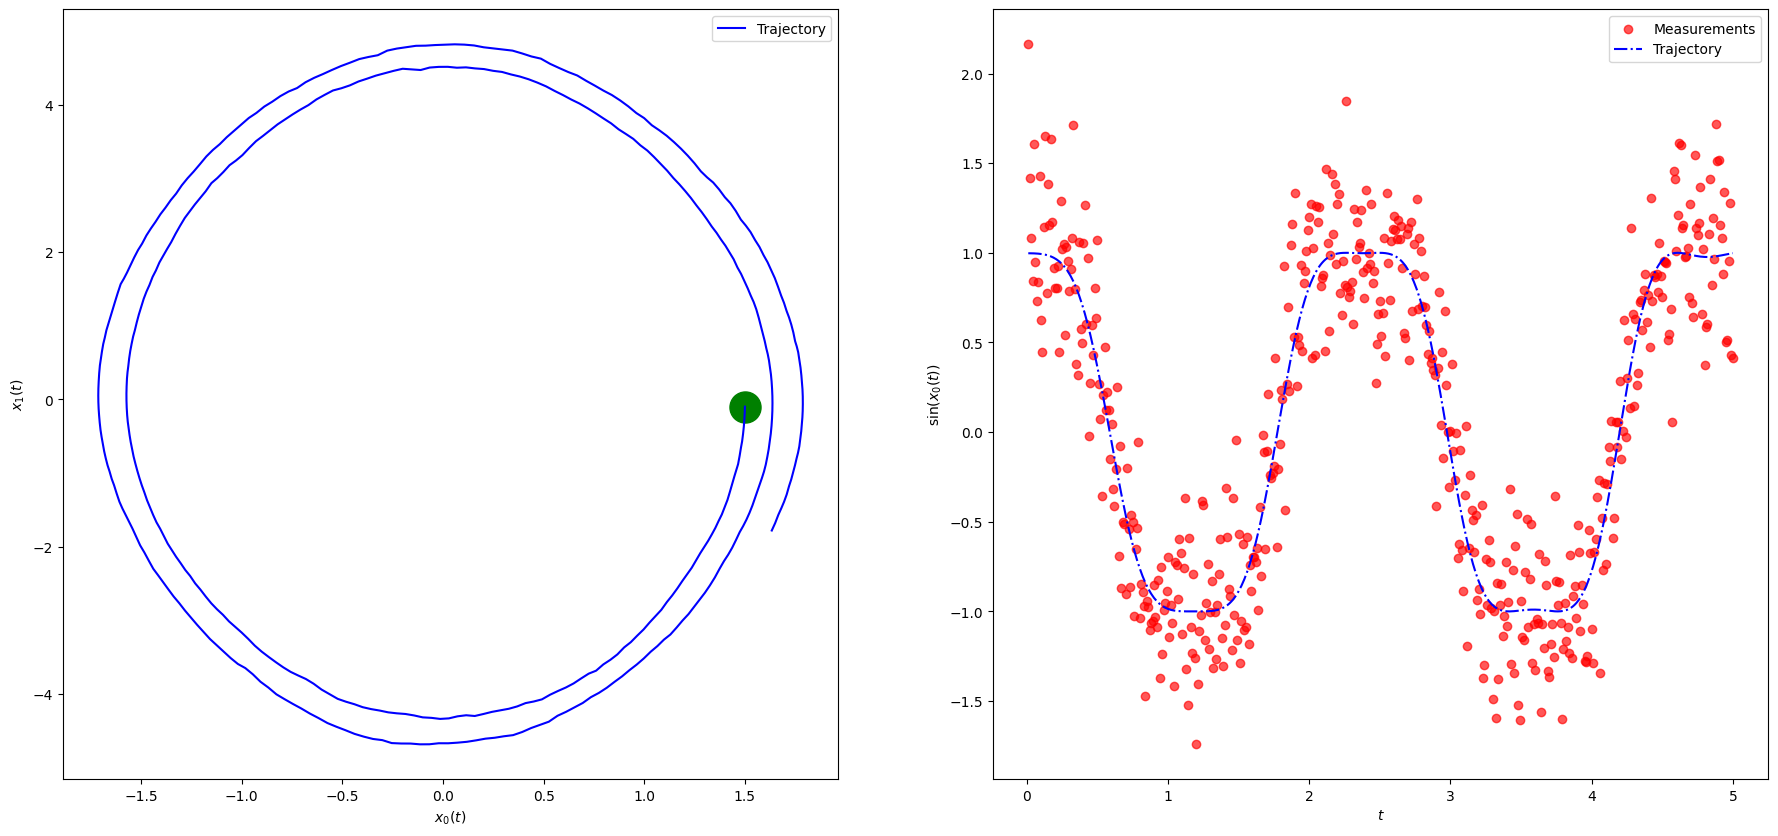

In [3]:
# Simulate trajectory and noisy measurements
random_state = RandomState(1)
steps = 500

timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)
plot_pendulum(timeline, observations, states, "Trajectory")

## Extended Kalman Filter (EKF)

In [5]:
def extended_kalman_filter(m_0, P_0, g, Q, dt, R, observations):
    n = m_0.shape[-1]
    steps = observations.shape[0]
    
    ekf_m = np.empty((steps, n))
    ekf_P = np.empty((steps, n, n))
    
    m = m_0[:]
    P = P_0[:]
    
    for i in range(steps):
        y = observations[i]
        
        # Jacobian of the dynamic model function
        Df = np.array([[1.,                     dt], 
                      [-g * dt * np.cos(m[0]), 1.]])
        
        # Predicted state distribution
        m = np.array([m[0] + dt * m[1],
                      m[1] - g * dt * np.sin(m[0])])
        P = Df @ P @ Df.T + Q
        
        # Predicted observation
        h  = np.sin(m[0])
        Dh = np.array([[np.cos(m[0]), 0.]])
        S = Dh @ P @ Dh.T + R
        
        # Kalman Gain
        K = linalg.solve(S, Dh @ P, assume_a="pos").T 
        m = m + K @ np.atleast_1d(y - h)
        P = P - K @ S @ K.T
        
        ekf_m[i] = m
        ekf_P[i] = P
    return ekf_m, ekf_P

EKF RMSE: 0.10306106181239276


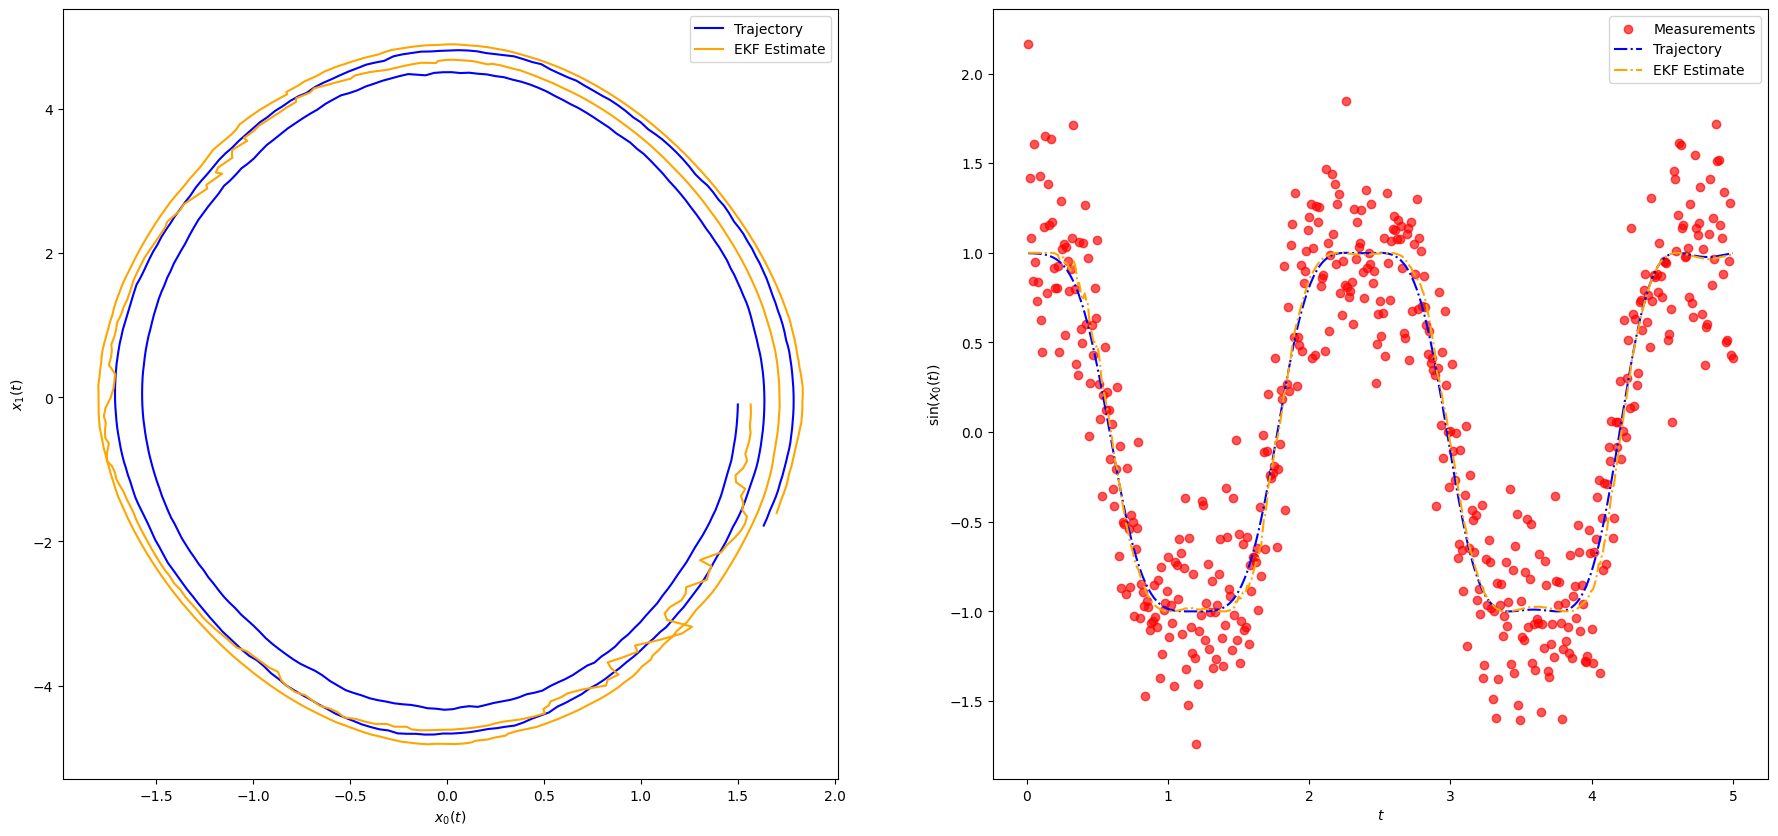

In [6]:
# initialize state and covariance
m_0 = np.array([1.6, 0.])  # Slightly off
P_0 = np.array([[0.1, 0.], 
                [0., 0.1]])

ekf_m, ekf_P = extended_kalman_filter(m_0, P_0, g, Q, dt, R, observations)
plot_pendulum(timeline, observations, states, "Trajectory", ekf_m, "EKF Estimate")

rmse_ekf = rmse(ekf_m[:, :1], states[:, :1])
print(f"EKF RMSE: {rmse_ekf}")

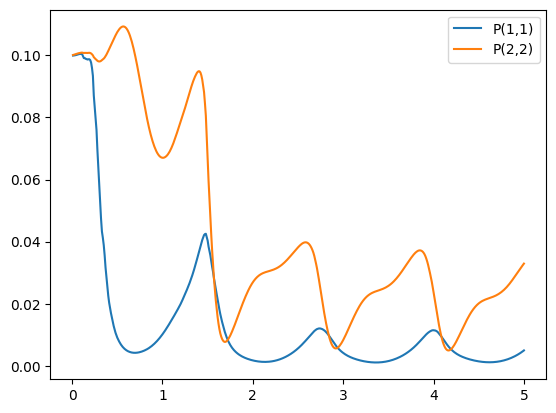

In [7]:
# plot covariances
plt.plot(timeline, ekf_P[:,0,0], timeline,ekf_P[:,1,1] )
plt.legend(['P(1,1)', 'P(2,2)'])
plt.show()

## Extended Smoother

In [8]:
def extended_smoother(ekf_m, ekf_P, g, Q, dt):    
    steps, M = ekf_m.shape
    
    rts_m = np.empty((steps, M))
    rts_P = np.empty((steps, M, M))
    
    m = ekf_m[-1]
    P = ekf_P[-1]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    for i in range(steps-2, -1, -1):
        filtered_m = ekf_m[i]
        filtered_P = ekf_P[i]
        
        Df = np.array([[1., dt], 
                      [-g * dt * np.cos(filtered_m[0]), 1.]])
        
        mp = np.array([filtered_m[0] + dt * filtered_m[1], 
                       filtered_m[1] - g * dt * np.sin(filtered_m[0])])
        Pp = Df @ filtered_P @ Df.T + Q
        
        # More efficient and stable way of computing Gk = filtered_P @ A.T @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a positive definite matrix (assume_a="pos")
        Gk = linalg.solve(Pp, Df @ filtered_P, assume_a="pos").T 

        m = filtered_m + Gk @ (m - mp)
        P = filtered_P + Gk @ (P - Pp) @ Gk.T
        
        rts_m[i] = m
        rts_P[i] = P

    return rts_m, rts_P

KF RMSE: 0.10306106181239276
ERTS RMSE: 0.027612762479911554


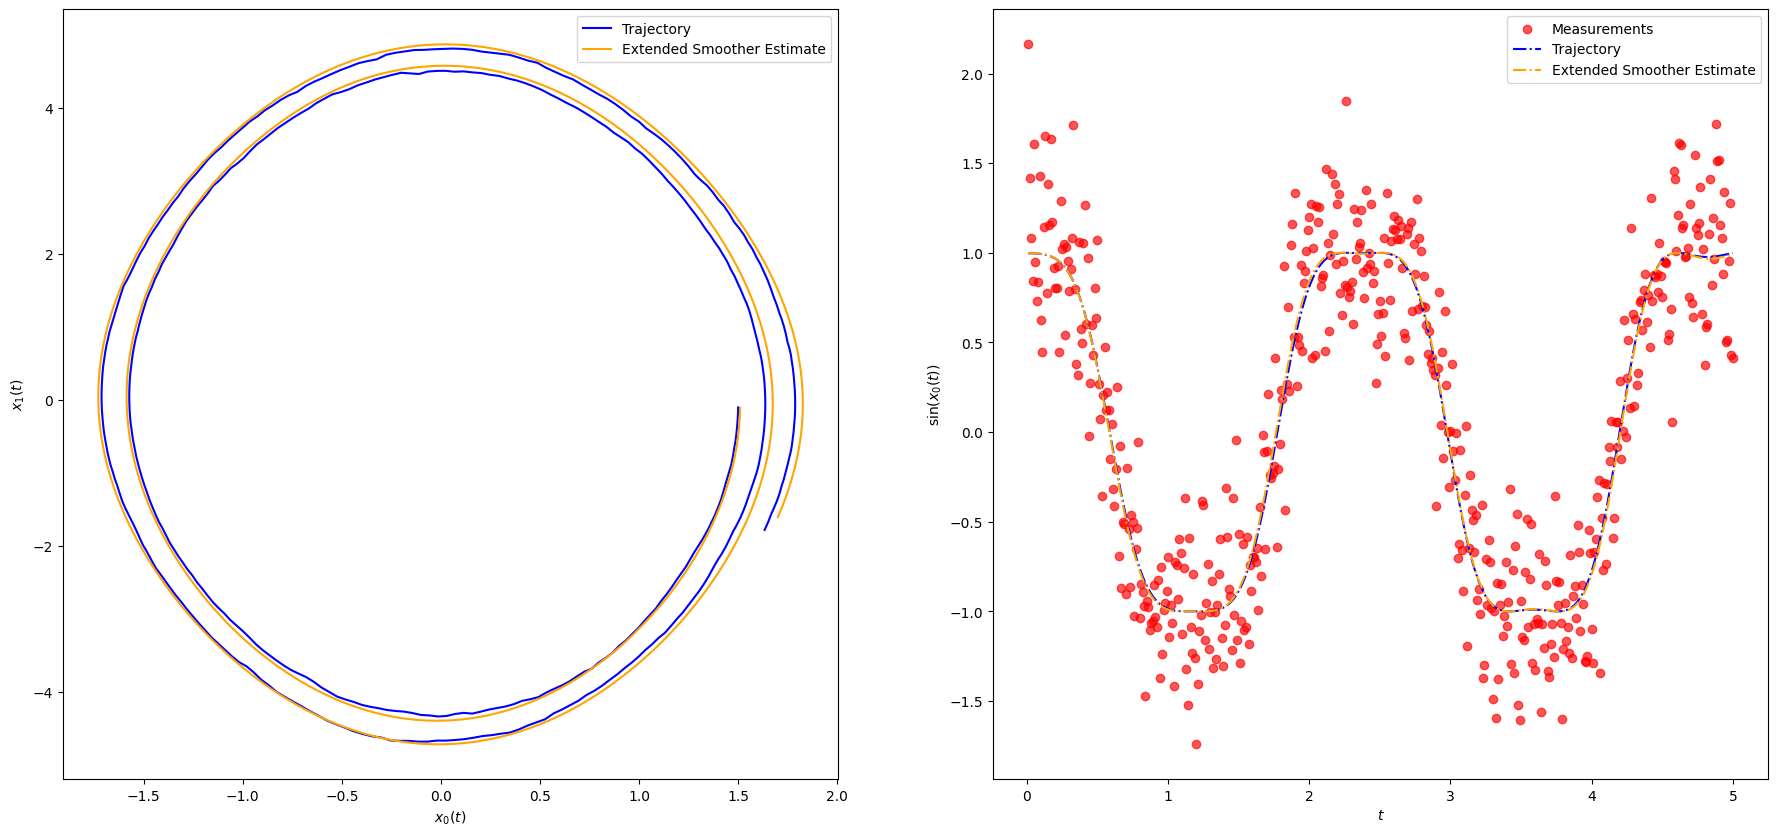

In [9]:
rts_m, rts_P = extended_smoother(ekf_m, ekf_P, g, Q, dt)
plot_pendulum(timeline, observations, states, "Trajectory", rts_m, "Extended Smoother Estimate")
rmse_erts = rmse(rts_m[:, :1], states[:, :1])
print(f"KF RMSE: {rmse_ekf}")
print(f"ERTS RMSE: {rmse_erts}")

## Conclusions on Extended Kalman Filters

The pros and cons of the EKF are:
- Pros:
  - Relative simplicity, based on well-known linearization methods.
  - Maintains the simple, elegant, and computationally efficient KF update equations.
  - Good performance for such a simple method.
  - Ability to treat nonlinear process and observation models.
  - Ability to treat both additive and more general nonlinear Gaussian noise.
- Cons:
  - Performance can suffer in presence of strong nonlinearity because of the local validity of the linear approximation (valid for small perturbations around the linear term).
  - Cannot deal with non-Gaussian noise, such as discrete-valued random variables.
  - Requires differentiable process and measurement operators and evaluation of Jacobian matrices, which might be problematic in very high dimensions.

In spite of this, the EKF remains a solid filter and remains the basis of most GPS and navigation systems.

## References

1. <a name="LSZ"></a> K. Law, A Stuart, K. Zygalakis. *Data Assimilation. A Mathematical Introduction.* Springer. 2015.
2. <a name="asch1"></a> M. Asch, M. Bocquet, M. Nodet. *Data Assimilation: Methods, Algorithms and Applications.* SIAM. 2016.
3. <a name="asch2"></a> M. Asch. *A Toobox for Digital Twins. From Model-Based to Data-Driven.* SIAM. 2022
4. <a name="sarkka"></a>  S. Sarkka, L. Svensson. *Bayesian Filtering and Smoothing,* 2nd ed., Cambridge University Press. 2023.